# Predicting a loan's success in kiva's crowdfinding platform
## Human-Agent interaction final project
### By Einat Heletz and Eyal Golan

# Table of Contents
1. [Introduction](#intro)
2. [Preprocessing](#preprocessing)
3. [Analyzing the data](#analyzing)
4. [Models](#Models)
5. [Final results](#results)
6. [Conclusions](#conclusions)

# <a class="anchor" id="intro">1. Introduction</a>
<b>What is Kiva?</b><br>
Kiva is a non-profit organization that allows people to lend money via the Internet to low-income entrepreneurs and
students in 77 countries.
Kiva's mission is "to expand financial access to help underserved communities thrive."
Since 2005, Kiva has crowd-funded more than 1.6 million loans, totaling over $1.33 billion, with a repayment rate of
95.8 percent. Over 1.8 million lenders worldwide use the Kiva platform. Lenders do not receive interest on the money
they lend. Kiva includes personal stories of each person who applies for a loan so that lenders can connect with
borrowers on a human level.<br>
<br><br>
<b>Motivation</b><br>
The Kiva platform is used to extend financial services to poor and financially excluded people around the world.
It's lenders have provided over billions of dollars in loans to millions of people.
Lender can decide to support a loan based on many different sets of values, agendas and concerns. The lenders don't meet
 the loaners face to face and need to decide wheather or not to support a loan - based only on the data provided by the
 lender.
 Therefore, out motiviation is to explore what exventually drive the lenders to the support the loans they do.
<br><br>
<b>Our goal</b><br>
As part of out final project in the Human-Agent interaction course, our goal is to determine which factors come to play
in a lender's decision to provide a load or not - Which factors give a lender the security he or she needs that they
will get the money back? which people do lenders tend to trust? why?

## Data
[Data Science for Good: Kiva Crowdfunding](https://www.kaggle.com/kiva/data-science-for-good-kiva-crowdfunding)

Explaining the data:
#### Kiva Crowdfunding - we use the following kiva_loans.csv. It contains the following fields:
   * id	- the id number of the loan request
   * funded_amount - The amount disbursed by Kiva to the field agent(USD)
   * loan_amount - The amount disbursed by the field agent to the borrower(USD)
   * activity - The activity for which the load is requested
   * sector - The category of the activity
   * use - The purpose of the loan
   * country_code - ISO country code of country in which loan was disbursed
   * country - Full country name of country in which loan was disbursed
   * region - Full region name within the country
   * currency - The currency in which the loan was disbursed
   * partner_id - Unique ID for field partners
   * posted_time
   * disbursed_time
   * funded_time
   * term_in_months
   * lender_count
   * tags - Additional information about the load, for example: #Woman Owned Biz, #Parent, #First Loan
   * borrower_genders - the gender of each of the borrowers

[Multidimensional Poverty Measures](https://www.kaggle.com/ophi/mpi)
#### MPI national - we use the following MPI_national.csv. It contains the following fields:
   * ISO: Unique ID for country
   * Country: country name
   * MPI Urban: Multi-dimensional poverty index for urban areas within the country
   * Headcount Ratio Urban: Poverty headcount ratio (% of population listed as poor) within urban areas within the country
   * Intensity of Deprivation Urban: Average distance below the poverty line of those listed as poor in urban areas
   * MPI Rural: Multi-dimensional poverty index for rural areas within the country
   * Headcount Ratio Rural: Poverty headcount ratio (% of population listed as poor) within rural areas within the country
   * Intensity of Deprivation Rural: Average distance below the poverty line of those listed as poor in rural areas


#### MPI subnational - we use the following MPI_Subnational.csv. It contains the following fields:
   * ISO: Unique ID for country
   * Country: country name
   * Sub-national region: Region within country
   * World region: General global region
   * MPI National: Overall aggregate national MPI score
   * MPI Regional: Multi-dimensional poverty index for this region
   * Headcount Ratio Regional: Poverty headcount ratio (% of population listed as poor) this region
   * Intensity of deprivation Regional: Average distance below the poverty line of those listed as poor in this region

# <a class="anchor" id="preprocessing">2. Preprocessing</a>

## Loading the data

In [1]:
import pandas as pd
import numpy as np
import math
import nltk
from nltk.tokenize import RegexpTokenizer
from tqdm import tqdm
import warnings
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    tqdm.pandas()

print("Loading the datasets ...")
loans = pd.read_csv(r"datasets/kiva_loans.csv")
loans_for_presenting_data = pd.read_csv(r"datasets/kiva_loans.csv")
mpi_region = pd.read_csv(r"datasets/MPI_subnational.csv")
mpi_country = pd.read_csv(r"datasets/MPI_national.csv")
print("Loaded all the datasets")

Loading the datasets ...


## Presenting the scope of kiva's activity worldwide

In [ ]:
# grouping by country and sorting the values based on counted values
loans_country = loans_for_presenting_data.groupby(['country'], as_index = False)['funded_amount'].count()

loans_country.sort_values(by=['funded_amount'], ascending=False, inplace=True)

# importing the iso_country codes to plot the choropleth graphs
country_codes = pd.read_csv(r"datasets/wikipedia-iso-country-codes.csv")

# renameing the column names
country_codes.columns = ['country','Alpha-2 code','Alpha-3 code','Numeric code', 'ISO 3166-2']

# combining the two data frames to get the country codes
country_merge_count = pd.merge(country_codes, loans_country, on='country', how='right')
country_merge_count.columns = ['country','Alpha-2 code','Alpha-3 code','Numeric code', 'ISO 3166-2', 'Total_loans']

fig = px.choropleth(country_merge_count, locations="Alpha-3 code",
                    color="Total_loans",
                   hover_name="country",
                   color_continuous_scale=px.colors.sequential.Plasma)

fig.update_layout(
    title_text = 'Number of loan requests per country')
#fig.show()

For some reason the figure isn't shown in nbviewer so wev'e added the image
manually:


![world_map](https://github.com/eyalgolan/HumanAgentInteraction/blob/master/world_map.png?raw=true)

## Detecting missing values

Before we dive into the dataset, we want to check how complete the dataset is.

<AxesSubplot:>

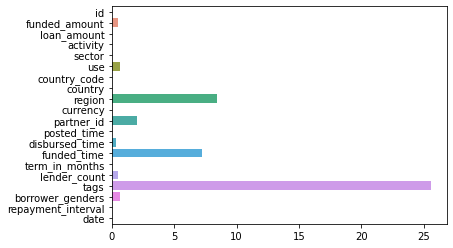

In [4]:
import seaborn as sns

missing_data_in_rows = dict()
for key in loans.keys():
    data = loans[key]
    count = 0
    for line in data:
        if not line or (type(line) == float and math.isnan(line)):
            count += 1
    missing_data_in_rows[key] = count/len(loans)*100
    #print(f'{key}: {count/len(loans)*100}% ({count}/{len(loans)})')# ({missing_data_in_rows[key]}/{count})')

keys = list(missing_data_in_rows.keys())
values = [missing_data_in_rows[k] for k in keys]
sns.barplot(y=keys, x=values)

## Handling missing values
funded_time - missing value actually means that it's an unsuccessful loan, so they will be labeled later as
unsuccessful. no issue here.

tags - we extract later features out of this field, doesn't necessarily need to be in all the samples. no issue here.

borrower_genders - handled in the Gender Features section.

region - will be handled later in a dedicated chapter.

partner_id - the missing values will be filled with 0.

lender_count - the missing values will be filled with 0.

country_code - the missing values will be filled with na.

use - the missing values will be filled with an empty string.

In [5]:
def fill_missing_values(field, value):
    missing_values_before = loans[field].apply(lambda x: 1 if type(x) is float and math.isnan(x) else 0).sum()
    loans[field] = loans[field].fillna(value)
    missing_values_after = loans[field].apply(lambda x: 1 if type(x) is float and math.isnan(x) else 0).sum()
    print(f'Missing values in {field} - before: {missing_values_before}, after: {missing_values_after}')

fill_missing_values('partner_id', 0)
fill_missing_values('lender_count', 0)
fill_missing_values('country_code', 'na')
fill_missing_values('use', '')

Missing values in partner_id - before: 13507, after: 0
Missing values in lender_count - before: 0, after: 0
Missing values in country_code - before: 8, after: 0
Missing values in use - before: 4232, after: 0


## Regional MPI
Our data consists of Loans, National MPI and Regional MPI. Each loans states the region of the borrower,
and we can use this data in our advance.
The region column on the loans dataset has a lot of unique values, which does not represnt a region directly,
some of the entries contain cities or district, and other have more data than just a region or a city. If we'd like to
use the regional MPI data set, we need to extract the region (and only the region) for each entry.
In order to use this data, we'll need to split cluttered entries and "zooming out" to get the region for most of the
entries. Additionally, some countries does not have Regional MPI data for us to use.

### Reviewing loans region column

In [6]:
missing = set()
for region in loans.region.unique(): #what if there are 2 different regions from different countries but with the same name?
    if region not in mpi_region['Sub-national region'].values:
        missing.add(region)
print(f"Amount of missing regions: {len(missing)}")

Amount of missing regions: 12565


Translating city to region won't be an easy job, considering all the different countries. An easier approach would be
fixing the larger chunk of data, doing the least job. So we'll find out how many entries we have for each country.

In [7]:
loans_geo_df = loans.groupby(['country','region']).size().reset_index(name='Freq')
loans_geo_country_df = loans.groupby(['country']).size().reset_index(name='Freq')

mpi_df = mpi_region[['Country', 'Sub-national region']]
mpi_df = mpi_df.rename(columns={'Country': 'country', 'Sub-national region': 'region'})
loans_geo_with_mpi_df = loans_geo_df.merge(mpi_df, indicator=True, how='outer', on=(['country', 'region']))
loans_geo_country_with_mpi_df = loans_geo_with_mpi_df.groupby(['country']).sum().sort_values('Freq', ascending=False)

missing_regions = int(loans_geo_with_mpi_df[loans_geo_with_mpi_df['_merge'] == 'left_only']['Freq'].sum())
missing_regions_top10 = int(loans_geo_country_with_mpi_df[:10].sum()['Freq'])

print(f"Amount of loans with missing regions: {missing_regions}")
print(f"Only in the top 10: {missing_regions_top10}")
print(f"{missing_regions_top10/missing_regions*100}%\n")
print(loans_geo_country_with_mpi_df[:10])

Amount of loans with missing regions: 563450
Only in the top 10: 405367
71.94373946224155%

                 Freq
country              
Philippines  160360.0
Kenya         67073.0
Cambodia      34811.0
Pakistan      26852.0
Peru          22073.0
Colombia      21218.0
Uganda        20390.0
El Salvador   19624.0
Tajikistan    19482.0
Ecuador       13484.0


We have total of 671205 loan entries. 563450 of them has a corrupted region info. Fixing the top 10 countries on that
list would fix 72% of the total regions. Fixing each country can be a tedious job for some countries (Kenya for
example, due to lack of useful, easy to use, data online), and even when addressing a country individually, we still
won't hit 100% success. Instead, we tried addressing the problem as a whole, and using some tools and some time we
managed to get some nice results. We decided to fill the missing MPI data with 0s.

### Reviewing missing countries in regional MPI
Let see which contries don't have regional MPI data, and total of how many entries don't have the relevant data.

c:\studies\barilan\year3\semesterb\humanagentinteraction\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



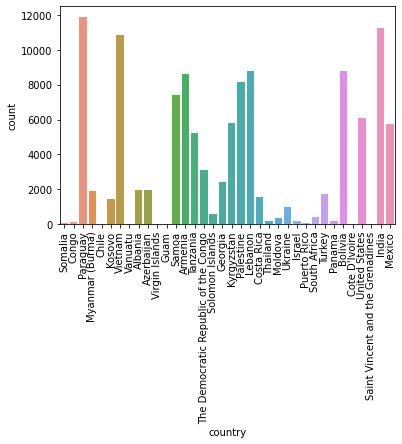

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
countries = set(loans['country'].unique()) - set(mpi_region['Country'].unique())
ax = sns.countplot(loans.country, order=countries)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [9]:
contries_count = loans.groupby('country').size()
print(f'In total, we have {len(countries)} countries without regional MPI data, which means we have '
      f'{contries_count[countries].sum()} non resolvable entries. \nWhich means '
      f'{contries_count[countries].sum()/len(loans)*100:.02f}% of our data is non-resolvable')

In total, we have 36 countries without regional MPI data, which means we have 117627 non resolvable entries. 
Which means 17.52% of our data is non-resolvable



### Fixing regions data
Our first method was resolved each country individually, or to do so for the 10 most common countries in the Kiva loans
dataset. First we started resolving the Philippines. It has a slightly complex divisioning system, and most of the
entries have more data then just the region itself, but we managed to resolved 95% of the entries (which means 10k
unresolved entries).
After the Philippines we started resolving Kenya. They have regions, but most of the data on the loans dataset is small
villages, which sometimes fail to yield result even on google. resolving all of the villages one by one would've been a
tedious job, so we gave up on that method.
Our current method is using geopy + translate + SequenceMatcher to find the best result.
The region_resolver script can be find outside of this notebook. It needs several hours to run, but it yields decent
results. Geopy returns location tokens, then we translate the token, because some of them are in foreign languages, and
then we take the region of the same country with a match of 85% or more using sequence matcher.

### Applying the results on the Dataset

In [10]:
import json
with open(r"datasets/regions.json", 'r') as fp:
    _, resolved_regions = json.load(fp).values()

def region_solver(x):
    if pd.isna(x.region):
        return 0
    new_region = resolved_regions[f'{x.country}, {x.region}']
    if isinstance(new_region, int):
        return 0
    return new_region

resolved = loans.progress_apply(region_solver, axis=1)
loans['region_new'] = resolved

100%|██████████| 671205/671205 [00:40<00:00, 16553.41it/s]


In [11]:
resolved_count = pd.DataFrame(resolved).groupby(0).size()
total_resolved = resolved_count.sum() - resolved_count[0]
print(f'We have resolved regions for {total_resolved} entries out of {resolved_count.sum()} which is '
      f'{total_resolved/resolved_count.sum() * 100:.2f}%')

We have resolved regions for 311366 entries out of 671205 which is 46.39%


### Merging with MPI regional & Fix missing values

In [12]:
loans_with_region_df = loans.query("region_new != 0")
loans_without_region_df = loans.query("region_new == 0")

loans_with_region_df = pd.merge(loans_with_region_df, mpi_region, left_on=['country','region_new'],
                                right_on=['Country', "Sub-national region"])

loans = pd.concat([loans_with_region_df, loans_without_region_df])

fill_missing_values('MPI National', 0)
fill_missing_values('MPI Regional', 0)
fill_missing_values('Headcount Ratio Regional', 0)
fill_missing_values('Intensity of deprivation Regional', 0)

<ipython-input-12-8ce608c5b457>:7: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




Missing values in MPI National - before: 359839, after: 0
Missing values in MPI Regional - before: 359839, after: 0
Missing values in Headcount Ratio Regional - before: 359839, after: 0
Missing values in Intensity of deprivation Regional - before: 359842, after: 0


We've resovled almost 50% of the regions data. It's not perfect, but it adds a lot of data and probaly gives us more
information than resolving a few countries individually.


## Country MPI
Here we join the country data from the MPI data. The MPI dataset was explained at the beginning of the notebook.

In [13]:
loans = pd.merge(loans, mpi_country, right_on='Country', left_on='country', how="left")


### Fixing missing values

In [14]:
fill_missing_values('MPI Urban', 0)
fill_missing_values('MPI Rural', 0)
fill_missing_values('Headcount Ratio Urban', 0)
fill_missing_values('Headcount Ratio Rural', 0)
fill_missing_values('Intensity of Deprivation Urban', 0)
fill_missing_values('Intensity of Deprivation Rural', 0)


Missing values in MPI Urban - before: 80765, after: 0
Missing values in MPI Rural - before: 80765, after: 0
Missing values in Headcount Ratio Urban - before: 80765, after: 0
Missing values in Headcount Ratio Rural - before: 80765, after: 0
Missing values in Intensity of Deprivation Urban - before: 80765, after: 0
Missing values in Intensity of Deprivation Rural - before: 80765, after: 0


## Labeling loans by Successful/Unsuccessful

We will classify the loans into 2 categories - 
1. Successful - A loan which has been fully funded by Kiva lender.
2. Unsuccessful - A partially funded loan.

The label will be based on the following condition:<br>
loan_amount - funded_amount == 0

unsuccessful loans: 48205, successful loans: 616912


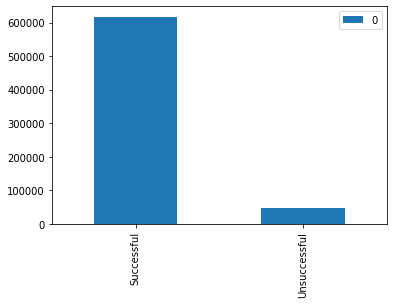

In [15]:
unsuccessful_loans_df = loans[loans['funded_amount'] < loans['loan_amount']]
successful_loans_df = loans[loans['funded_amount'] == loans['loan_amount']]
print(f'unsuccessful loans: {len(unsuccessful_loans_df)}, successful loans: {len(successful_loans_df)}')

ax = pd.DataFrame([len(successful_loans_df), len(unsuccessful_loans_df)],
                  index=["Successful", "Unsuccessful"]).plot(kind="bar")

In [16]:
successful_loans_df.loc[:,'Key'] = 'Successful'
unsuccessful_loans_df.loc[:,'Key'] = 'Unsuccessful'
loans_with_label = pd.concat([successful_loans_df, unsuccessful_loans_df]).reset_index(drop=True)

C:\Users\eyalg\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\eyalg\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#  <a class="anchor" id="analyzing">3. Analyzing the data</a>
We will take fields from different columns and generate features from them. Some examples:
1. Tags - some interesting tags can produce a boolean feature (exists or not)
2. "is_funded" (boolean) - loan_amount - funded_amount == 0

## Gender Features
We will extract 3 features: amount of borrowers, the existence of a feminine and the existence of a masculine.<br>
In case of missing value in the borrower_genders field, the values are defined as follows, correspondingly: 0, False, False.

In [17]:
loans_with_label['borrowers_amount'] = loans_with_label.apply(lambda r:len(r.borrower_genders.split(',')) if type(r.borrower_genders) is str else 0, axis=1)
loans_with_label['has_female'] = loans_with_label.apply(lambda r:'female' in r.borrower_genders.split(',') if type(r.borrower_genders) is str else False, axis=1)
loans_with_label['has_male'] = loans_with_label.apply(lambda r:'male' in r.borrower_genders.split(',') if type(r.borrower_genders) is str else False, axis=1)

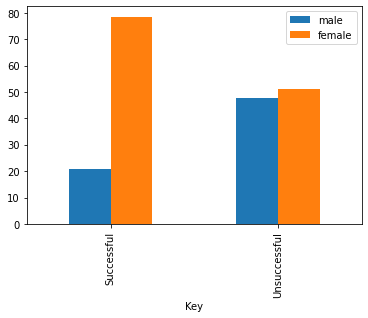

In [18]:
males_count = loans_with_label.groupby(['Key', 'has_male']).size().unstack('has_male')[True]
females_count = loans_with_label.groupby(['Key', 'has_female']).size().unstack('has_female')[True]
gender_df = pd.DataFrame([males_count, females_count], index=['male', 'female'])
gender_df["Successful"] = gender_df["Successful"].apply(lambda x: x / len(successful_loans_df) * 100)
gender_df["Unsuccessful"] = gender_df["Unsuccessful"].apply(lambda x: x / len(unsuccessful_loans_df) * 100)
ax = gender_df.transpose().plot(kind="bar")

#### Results
This barplot shows the percentage of loans with male and female borrowers in successful and unsuccessful loans separately

In [19]:
# Created a function to correct the multiple entry of the gender
def classify_entry_genders(borrower_genders):
    gender_list = borrower_genders.split(",")
    gender_list = list(set(gender_list))
    gender_list = [borrower_genders.strip() for borrower_genders in gender_list]
    if len(gender_list) == 2:
        if 'female' in gender_list and 'male' in gender_list:
            return 'both'
        elif 'female' in gender_list:
            return 'multiple female'
        elif 'male' in gender_list:
            return 'multiple male'
    elif gender_list[0]=='female':
        return 'female'
    elif gender_list[0]=='male':
        return 'male'
    else:
        return 'unknown'

loans_for_presenting_data['borrower_genders'][loans_for_presenting_data['borrower_genders'].isnull()]= 'unknown'
loans_for_presenting_data['gender'] = loans_for_presenting_data['borrower_genders'].apply(classify_entry_genders)
loans_gender_con= loans_for_presenting_data.groupby(['country', 'gender'], as_index=False).agg({'funded_amount':'sum',
                                                                            'loan_amount':'sum',
                                                                            'term_in_months':'mean',
                                                                            'lender_count':'sum'})
loans_gender_con['success_rate'] = round((loans_gender_con['funded_amount']/loans_gender_con['loan_amount'])*100)

loans_gender_con['new_success_rate'] = np.where(loans_gender_con['success_rate']< 70, 'low success rate',
                                               np.where(loans_gender_con['success_rate']>=95, 'high success rate',
                                                        'moderate success rate'))

fig = px.sunburst(loans_gender_con, path=['gender', 'new_success_rate'], values='success_rate', width =800,
                  height =800)

fig.show()

<ipython-input-19-06d8835f0c2a>:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Extracting the loan's use
The use column contains free text for the lenders to describe the purpose of their loan.


First we will take a quick look at the data using wordcloud to get the general idea for the usage of the loans, and
what the lenders need the money for.


And then we'll extract some features from the text.


### Exploring
The use columns is a free text that describes the purpose of the loan, using a wordcloud can give the essence of
successful and unsuccessful loans.

In [20]:
nltk.download('stopwords')

stop_words = set(nltk.corpus.stopwords.words('english')) 
tokenizer = RegexpTokenizer(r'\w+')
final = []
for use in successful_loans_df.use:
    if type(use) != str:
        continue
    tokenized = tokenizer.tokenize(use)
    filtered = [w.lower() for w in tokenized if w not in stop_words]
    final.extend(filtered)
final_successful = " ".join(final)

stop_words = set(nltk.corpus.stopwords.words('english')) 
tokenizer = RegexpTokenizer(r'\w+')
final = []
for use in unsuccessful_loans_df.use:
    if type(use) != str:
        continue
    tokenized = tokenizer.tokenize(use)
    filtered = [w.lower() for w in tokenized if w not in stop_words]
    final.extend(filtered)
final_unsuccessful = " ".join(final)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eyalg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Word cloud for successful loans


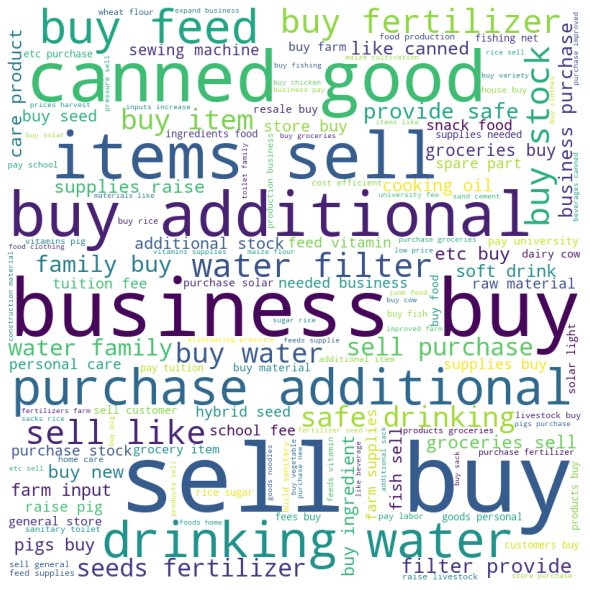

In [21]:
word_cloud = WordCloud(width = 800, height = 800,
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(final_successful)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(word_cloud)
plt.axis("off") 
plt.tight_layout(pad = 0) 

print("Word cloud for successful loans")

plt.show() 

Word cloud for unsuccessful loans


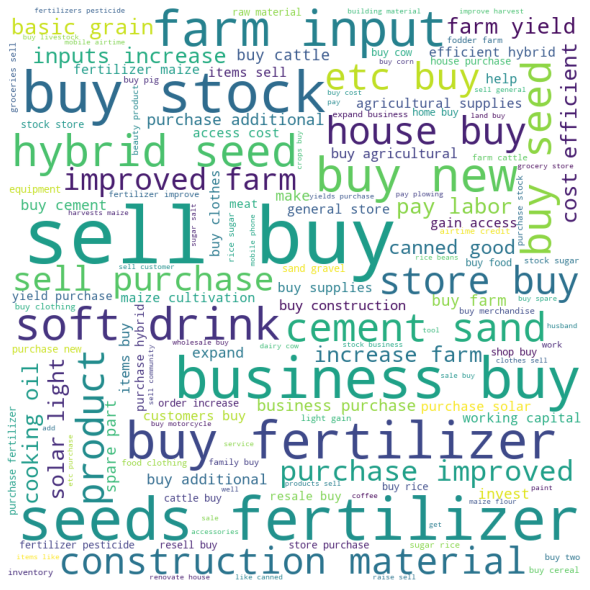

In [22]:
word_cloud = WordCloud(width = 800, height = 800,
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(final_unsuccessful)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(word_cloud)
plt.axis("off") 
plt.tight_layout(pad = 0) 

print("Word cloud for unsuccessful loans")

plt.show()

### Results

Viewing the word clouds we can see that the words such as "water", "safe drinking", "water filter" are used in
successful loans, whereas "buy", "sell", "soft drink" and "business" are used more in unsuccessful loans.

### Extracting Lexical Diversity, Text Length and Word Count
We will extract 4 features: Lexical Diversity, Text Length and Word Count.

#### Filling missing data
We fill the missing data in order to avoid errors

In [23]:
def fill_missing_values(field, value):
    missing_values_before = loans_with_label[field].apply(lambda x: 1 if type(x) is float and math.isnan(x) else 0).sum()
    loans_with_label[field] = loans_with_label[field].fillna(value)
    missing_values_after = loans_with_label[field].apply(lambda x: 1 if type(x) is float and math.isnan(x) else 0).sum()
    print(f'Missing values in {field} - before: {missing_values_before}, after: {missing_values_after}')

fill_missing_values('partner_id', 0)
fill_missing_values('lender_count', 0)
fill_missing_values('country_code', 'na')
fill_missing_values('use', '')

Missing values in partner_id - before: 0, after: 0
Missing values in lender_count - before: 0, after: 0
Missing values in country_code - before: 0, after: 0
Missing values in use - before: 0, after: 0


#### Checking the effect of each feature
We want to check how the 4 feature - Lexical Diversity, Text Length, Word Count and TF/IDF - effect the choice of the
borrower.

#### lexical diversity and word count
we check the effect of the loan's use field lexical diversity and the number of words in the use field -
on the borrowers.

In [24]:
nltk.download('punkt')

unique_words = dict()
def lexical_diversity(text):
    tokenized_text = nltk.word_tokenize(text)
    if len(tokenized_text) == 0:
        return 0
    for i in tokenized_text:
        try:
            unique_words[i] += 1
        except Exception as e:
            unique_words[i] = 1
    return len(set(tokenized_text)) / len(tokenized_text)

loans_with_label['lexical_diversity'] = loans_with_label['use'].progress_apply(lexical_diversity)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eyalg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████| 665117/665117 [01:30<00:00, 7383.24it/s] 


In [25]:
loans_with_label['use_length'] = loans_with_label['use'].apply(lambda x: len(x))
loans_with_label['word_count'] = loans_with_label['use'].progress_apply(lambda x: len(nltk.word_tokenize(x)))

100%|██████████| 665117/665117 [01:18<00:00, 8455.36it/s] 


In [26]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

filtered_use = loans['use'].apply(lambda x: x if not pd.isna(x) else "")

tfidf_vectorizer = TfidfVectorizer(use_idf=True)
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(filtered_use)

# get the first vector out (for the first document)
first_vector_tfidfvectorizer = tfidf_vectorizer_vectors[0]

# place tf-idf values in a pandas data frame
temp_df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
tfidf_df = temp_df.sort_values(by=["tfidf"],ascending=False)

In [27]:
tokenizer = nltk.RegexpTokenizer(r'\w+')
def tfidf_extraction(use):
    values = []
    for i in tokenizer.tokenize(use):
        i = i.lower()
        if i not in tfidf_df.index:
            continue
        values.append(tfidf_df.loc[i].iloc[0])
    return np.array(values).max(initial=0)

loans_with_label['tfidf'] = loans_with_label['use'].progress_apply(tfidf_extraction)

100%|██████████| 665117/665117 [14:59<00:00, 739.63it/s] 


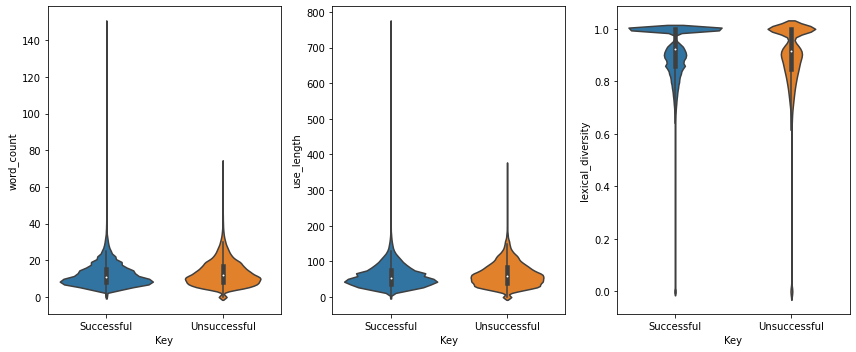

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,5))
ax = sns.violinplot(x="Key", y="word_count", data=loans_with_label, ax=axes[0])
ax = sns.violinplot(x="Key", y="use_length", data=loans_with_label, ax=axes[1])
ax = sns.violinplot(x="Key", y="lexical_diversity", data=loans_with_label, ax=axes[2])

plt.tight_layout()
plt.show()

#### Results
After analyzing the plots, it seems that the successful loans have a shorter but richer sentence in the use field.

## Extracting the posted date
The dataset has 3 different date columns. Posted, funded and disbursed. <br>
- Funded time is not usable because has 100% correlation with our label (If a fund hasn't been fully funded,
it won't have funded time)
- Disbursed time column has too many missing entries.
- Posted time is the only useful column, so we'll be using it for our features.

We add 4 numeric features (day, month, year, day in the week)

In [29]:
def time_to_feature(date_):
    date_ = datetime.strptime(date_, "%Y-%m-%d %H:%M:%S+00:00")
    return pd.Series({"posted_year": date_.year, "posted_month": date_.month, "posted_day": date_.day, "posted_weekday": date_.weekday(), "posted_hour": date_.hour})

posted_time_series = loans_with_label['posted_time'].progress_apply(time_to_feature)

100%|██████████| 665117/665117 [03:36<00:00, 3076.86it/s]


In [30]:
loans_with_label = loans_with_label.merge(posted_time_series, left_index=True, right_index=True)

## Tags
The tags column contains one cell for each loan entry.
This single cell might contain more than one tag, in order to use this data we'll have to create a feature for each
different tag that exists in dataset set. <br>
The tags column might be useful, so we will have to preprocess it.<br>
This section adds tags as independent columns. It takes a while to compute.

### Tags preprocessing

In [31]:
def get_tag_list(tags):
    stags = set()
    if type(tags) != str:
        return set()
    tags = tags.split(",")
    for tag in tags:
        tag = tag.strip("# '")
        stags.add(tag)
    return stags

all_tags = set()
for tags in loans.tags:
    all_tags.update(get_tag_list(tags))
print(f'Total tags obtained: {len(all_tags)}')

loans_with_label['tag_list'] = loans_with_label.apply(lambda r: get_tag_list(r['tags']), axis=1)

Total tags obtained: 35


### Tags extraction
Adding each tag as a feature

In [32]:
for tag in tqdm(all_tags):
    loans_with_label[f'{tag}_tag'] = loans_with_label.apply(lambda r: tag in r['tag_list'], axis=1)
    

100%|██████████| 35/35 [05:50<00:00, 10.00s/it]


### Tags selection

Processing the effect of the tags on the loan's success

In [33]:
tag_names = [tag + '_tag' for tag in all_tags]
tags_df = pd.DataFrame(index=tag_names, columns =['successful', 'unsuccessful'])
appearance_tags_df = pd.DataFrame(columns =['successful', 'unsuccessful'])
successful_with_tags = loans_with_label.query("Key == 'Successful'")
unsuccessful_with_tags = loans_with_label.query("Key == 'Unsuccessful'")
for tag in tag_names:    
    sudf_num = int(successful_with_tags[successful_with_tags[tag] == 1].count().iloc[0] / successful_with_tags.count().iloc[0] * 100)
    undf_num = int(unsuccessful_with_tags[unsuccessful_with_tags[tag] == 1].count().iloc[0] / unsuccessful_with_tags.count().iloc[0] * 100)
    tags_df.loc[tag] = [sudf_num, undf_num]
    if sudf_num != 0 or undf_num != 0:
        appearance_tags_df.loc[tag] = [sudf_num, undf_num]


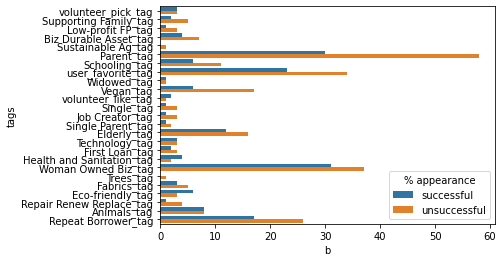

In [34]:
appearance_tags_df.index.name = 'tags'
tags_df_melted = appearance_tags_df.reset_index().melt(var_name='% appearance', value_name='b', id_vars=['tags'])
ax = sns.barplot(y='tags', x='b', hue='% appearance', data=tags_df_melted)

#### Results

Looking at the results - it seems that the tags: Technology, Fabrics, Eco-Friendly, Health and Sanitation are the top
 tags for successful loans. However, the Refugee and Interesting photo tags were always in unsuccessful loans.

using only 'user_favorite' tag

In [35]:
tags_selected = ['user_favorite_tag']

### Loan amount by sector

Here we get an impression of which loan sectors are more likely to be funded.

<AxesSubplot:xlabel='sector'>

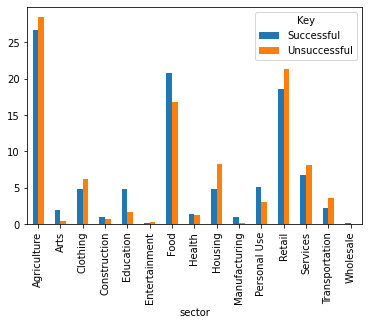

In [36]:
sectors = loans.sector.unique()

sector_loans_df = loans_with_label.groupby(["sector", "Key"]).size().unstack("Key")
sector_loans_df["Successful"] = sector_loans_df["Successful"].apply(lambda x: x / len(successful_loans_df) * 100)
sector_loans_df["Unsuccessful"] = sector_loans_df["Unsuccessful"].apply(lambda x: x / len(unsuccessful_loans_df) * 100)
sector_loans_df.plot(kind="bar")

#### Results

The ratios seem to be even among successful and unsuccessful loans, but some field seem to be more likely to be more
successful (Personal use, Education and food).

#### Loan amount by sector

Let's look at average loan amount per sector of successful and unsuccessful loans:

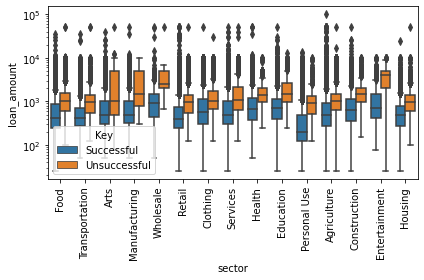

In [37]:
ax = sns.boxplot(x="sector", y="loan_amount", data=loans_with_label, hue="Key")
ax.set_yscale("log")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

#### Results

For each sector, the average loan amount is greater on unsuccessful loans.

We can also see which sector requests for higher loans, and what is the average request that succeeds (for each sector).

#### Loan amount

Let's look at the average loan amount of successful and unsuccessful loans:

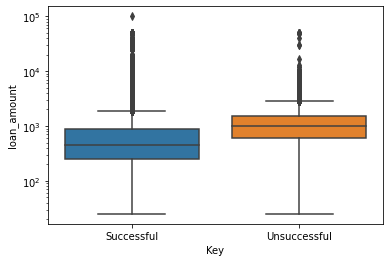

In [38]:
ax = sns.boxplot(x="Key", y="loan_amount", data=loans_with_label)
ax.set_yscale('log')
plt.show()

#### Results

On average, unsuccessful loans request higher amounts.

### Term in months

Let's look at the term in months of successful and unsuccessful loans:

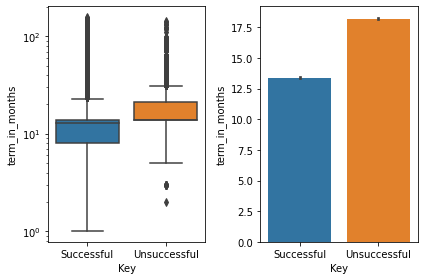

In [39]:
plt.subplot(1, 2, 1)
ax = sns.boxplot(x="Key", y="term_in_months", data=loans_with_label)
ax.set_yscale('log')
plt.subplot(1, 2, 2)
ax = sns.barplot(x="Key", y="term_in_months", data=loans_with_label)

plt.tight_layout()
plt.show()

#### Results

We can see here that on average, unsuccessful loans request for a longer term to return the loans.

#### Repayment interval

Let's look at the repayment interval of successful and unsuccessful loans:

<AxesSubplot:xlabel='repayment_interval'>

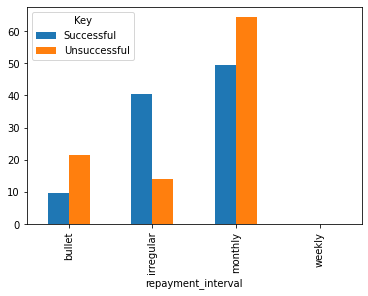

In [40]:
repayment_intervals = loans_with_label.repayment_interval.unique()


loans_by_repayment = loans_with_label.groupby(["Key", "repayment_interval"]).size().unstack("Key")
loans_by_repayment["Successful"] = loans_by_repayment["Successful"].apply(lambda x: x / len(successful_loans_df) * 100)
loans_by_repayment["Unsuccessful"] = loans_by_repayment["Unsuccessful"].apply(lambda x: x / len(unsuccessful_loans_df) * 100)
loans_by_repayment.plot(kind="bar")

#### MPI

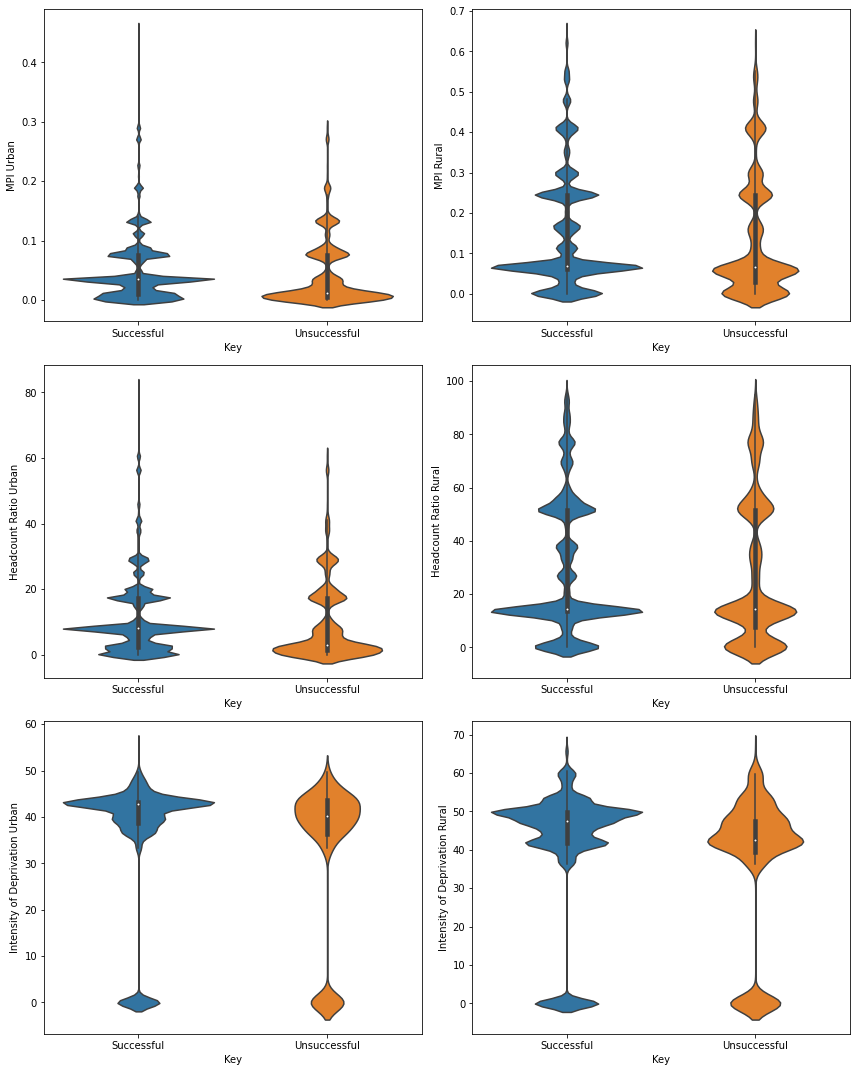

In [41]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,15))

ax = sns.violinplot(x="Key", y="MPI Urban", data=loans_with_label, ax=axes[0, 0])
ax = sns.violinplot(x="Key", y="MPI Rural", data=loans_with_label, ax=axes[0, 1])
ax = sns.violinplot(x="Key", y="Headcount Ratio Urban", data=loans_with_label, ax=axes[1, 0])
ax = sns.violinplot(x="Key", y="Headcount Ratio Rural", data=loans_with_label, ax=axes[1, 1])
ax = sns.violinplot(x="Key", y="Intensity of Deprivation Urban", data=loans_with_label, ax=axes[2, 0])
ax = sns.violinplot(x="Key", y="Intensity of Deprivation Rural", data=loans_with_label, ax=axes[2, 1])

plt.tight_layout()
plt.show()

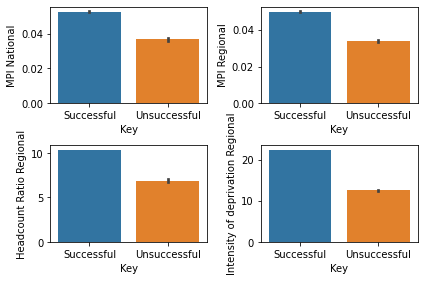

In [42]:
plt.subplot(2, 2, 1)
ax = sns.barplot(x="Key", y="MPI National", data=loans_with_label)
plt.subplot(2, 2, 2)
ax = sns.barplot(x="Key", y="MPI Regional", data=loans_with_label)
plt.subplot(2, 2, 3)
ax = sns.barplot(x="Key", y="Headcount Ratio Regional", data=loans_with_label)
plt.subplot(2, 2, 4)
ax = sns.barplot(x="Key", y="Intensity of deprivation Regional", data=loans_with_label)
plt.tight_layout()
plt.show()

These plots show the MPI information of successful and unsuccessful loans.
The pattern is that the MPI index is greater among the successful loans, on average, for both the regional MPI and
National MPI.
This means, that most of the successful loans are aimed toward countries with higher MPI index (or in other words, the
people who needs the loans the most)

### Selected features

In [43]:
selected_features_df = loans_with_label.loc[:, ['Key',
    'loan_amount', 'sector', 'activity', 'term_in_months', 'repayment_interval',
    'MPI Urban', 'Headcount Ratio Urban', 'Intensity of Deprivation Urban', 'MPI Rural', 'Headcount Ratio Rural',
    'Intensity of Deprivation Rural', 'partner_id', 'country_code', 'borrowers_amount', 'has_male', 'has_female',
    'posted_year','posted_month', 'posted_day', 'posted_weekday',
    'lexical_diversity', 'use_length', 'word_count',  'lender_count',
    'MPI National', 'MPI Regional', 'Headcount Ratio Regional', 'Intensity of deprivation Regional',
    'tfidf',
] + tags_selected]
print(f'number of features: {len(selected_features_df.columns)}')

number of features: 31


In [44]:
selected_features_df.groupby("Key").size()

Key
Successful      616912
Unsuccessful     48205
dtype: int64


## Encoding

We have some other relevant features to be encoded before we can use them.


### Encoding Features
Now we will encode the feature on the whole dataset.

In [99]:
from sklearn.preprocessing import LabelEncoder

sector_le = LabelEncoder()
activity_le = LabelEncoder()
pay_int_le = LabelEncoder()
country_code_le = LabelEncoder()
has_male_le = LabelEncoder()
has_female_le = LabelEncoder()

In [100]:
country_code_le.fit(selected_features_df['country_code'])

sector_le.fit(selected_features_df['sector'].unique())
activity_le.fit(selected_features_df['activity'].unique())
pay_int_le.fit(selected_features_df['repayment_interval'])
selected_features_df['sector'] = sector_le.transform(selected_features_df['sector'])
has_male_le.fit(selected_features_df['has_male'])
has_female_le.fit(selected_features_df['has_female'])

selected_features_df['activity'] = activity_le.transform(selected_features_df['activity'])
selected_features_df['repayment_interval'] = pay_int_le.transform(selected_features_df['repayment_interval'])
selected_features_df['country_code'] = country_code_le.transform(selected_features_df['country_code'])
selected_features_df['has_male'] = has_male_le.transform(selected_features_df['has_male'])
selected_features_df['has_female'] = has_male_le.transform(selected_features_df['has_female'])

for tag in tags_selected:
    le = LabelEncoder()
    le.fit(selected_features_df[tag])
    selected_features_df[tag] = le.transform(selected_features_df[tag])

In [101]:
selected_features_df.describe()

,loan_amount,sector,activity,term_in_months,repayment_interval,MPI Urban,Headcount Ratio Urban,Intensity of Deprivation Urban,MPI Rural,Headcount Ratio Rural,...,lexical_diversity,use_length,word_count,lender_count,MPI National,MPI Regional,Headcount Ratio Regional,Intensity of deprivation Regional,tfidf,user_favorite_tag
count,665117.000000,665117.000000,665117.000000,665117.000000,665117.000000,665117.000000,665117.000000,665117.000000,665117.000000,665117.000000,...,665117.000000,665117.000000,665117.000000,665117.000000,665117.000000,665117.000000,665117.000000,665117.000000,665117.000000,665117.000000
mean,846.271295,5.834852,75.668815,13.757596,1.401684,0.046932,10.621469,36.729878,0.145019,28.949716,...,0.912441,59.799587,12.165216,20.664446,0.051539,0.048803,10.078361,21.598079,0.183207,0.322067
std,1202.787342,4.532911,38.904545,8.609834,0.674406,0.051714,10.960882,13.961173,0.139092,25.213155,...,0.112563,30.169301,6.126852,28.554787,0.088832,0.081562,15.966270,23.646640,0.054066,0.467269
min,25.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,275.000000,0.000000,57.000000,8.000000,1.000000,0.010000,2.400000,38.600000,0.061000,13.670000,...,0.857143,38.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.172997,0.000000
50%,500.000000,6.000000,72.000000,13.000000,2.000000,0.035000,8.100000,42.700000,0.068000,14.440000,...,0.923077,54.000000,11.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.172997,0.000000
75%,1000.000000,11.000000,112.000000,14.000000,2.000000,0.076000,17.300000,43.300000,0.245000,51.440000,...,1.000000,76.000000,15.000000,24.000000,0.052000,0.055000,11.600000,48.300000,0.172997,1.000000
max,100000.000000,14.000000,162.000000,158.000000,3.000000,0.459000,82.500000,55.700000,0.651000,96.920000,...,1.000000,772.000000,150.000000,2986.000000,0.557000,0.594000,93.000000,65.600000,0.646403,1.000000


### Biased encoding
On our previous attempt we separated the label using different dataframes
(we didn't merge unsuccessful_loans_df and successful_loans_df). When we applied and processed the features, we've done
the processing for both the dataframes.
Eventually, when we reached the encoding, we had to encode them separately as well. Since we've encoded the successful
and unsuccessful entries one after the other, our encoded data had biased value.
The data was biased because some of the encoded value existed only in one of the datasets, so the DNN could classify
the data with a great success rate using only the encoded data.

# <a class="anchor" id="Models">4. Models</a>

After analyzing the data, we wanted to see if we can predict the success of a loan based on its data.

We created 3 DNN models:

1. The first DNN, basic MLPClassifier - does not include regional MPI data.
2. In the second DNN, we tried to deal with the unbalanced dataset using oversampling.
The successful loans amount in the training set is double in size, compared to the unsuccessful loans amount.
Does not include regional MPI data.
3. The last DNN includes the regional MPI features. Except that, it was trained on the same dataset as the first DNN
model, so it should be compared to it.

## Randomizing and initial sizes

In [102]:
from collections import Counter
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# selected_features_df = selected_features_df.sample(frac=1).reset_index(drop=True)
sudf_main = selected_features_df.query("Key == 'Successful'").drop(["Key"], axis=1)
undf_main = selected_features_df.query("Key == 'Unsuccessful'").drop(["Key"], axis=1)
sudf_main = sudf_main.sample(frac=1).reset_index(drop=True)
undf_main = undf_main.sample(frac=1).reset_index(drop=True)
print(f'amount of successful loans: {len(sudf_main)}')
print(f'amount of unsuccessful loans: {len(undf_main)}')

amount of successful loans: 616912
amount of unsuccessful loans: 48205


## Basic MLPClassifier
The Basic MLPClassifier model includes all the features we have seen above in the feature processing sections.
The data was not oversampled. Also, it doesn't include any new features.

### Composition
Since there are less unsuccessful loans, we took 2/3 of them for training and corresponding amount from the successful
loans. The rest (a third of the unsuccessful and a corresponding amount of the successful) will be used for test.<br>

In [103]:
sudf = sudf_main.drop(['MPI National', 'MPI Regional', 'Headcount Ratio Regional', 'Intensity of deprivation Regional'], axis=1)
undf = undf_main.drop(['MPI National', 'MPI Regional', 'Headcount Ratio Regional', 'Intensity of deprivation Regional'], axis=1)

In [104]:
# take only 2/3 of the data for training (based on undf size, since undf is 39,878 and sudf is 550,560)
count = int(len(undf) * 2 / 3)
print(f'size of training set (successful and unsuccessful): {count*2}')
Y = []
Y.extend(np.zeros(count)) # for unsuccessful loans - undf
Y.extend(np.ones(count)) # for successful loans - sudf
Y = np.array(Y)
X = pd.concat([undf[:count], sudf[:count]], ignore_index=True)

# predict test set - 1/3 of the undf data, or 1/2 of the training set
end_test_set_count = int(3*count/2) + 1
print(f'size of test set (successful and unsuccessful): {count}')

X_test = pd.concat([undf[count:], sudf[count:end_test_set_count]], ignore_index=True).reset_index(drop=True)
y_test = np.concatenate((np.zeros(int(count/2)+1), np.ones(int(count/2)+1)))


size of training set (successful and unsuccessful): 64272
size of test set (successful and unsuccessful): 32136


### Training

In [105]:
classifier = MLPClassifier(max_iter=500, hidden_layer_sizes=(15, 15, 15))
clf = make_pipeline(StandardScaler(),classifier)
clf.fit(X, Y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=(15, 15, 15), max_iter=500))])

### Testing

[[0.92426411 0.07573589]
 [0.08650196 0.91349804]]


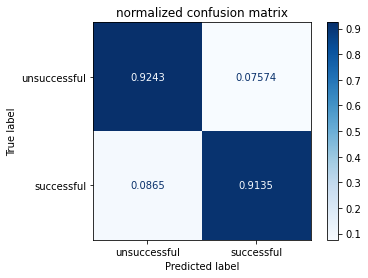

In [106]:
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(clf, X_test, y_test,
                             display_labels=['unsuccessful','successful'],
                             cmap=plt.cm.Blues,
                             normalize='true',
                            values_format='.4g')
disp.ax_.set_title('normalized confusion matrix')
print(disp.confusion_matrix)


### Results Analysis

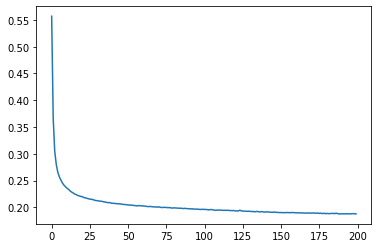

In [107]:
plt.plot(classifier.loss_curve_)

### Testing the remaining successful loans
Since we don't use all the successful loans, we can utilize the rest as another benchmark on successful loans solely.
The results are pretty impressive.

[[0.         0.        ]
 [0.08712225 0.91287775]]


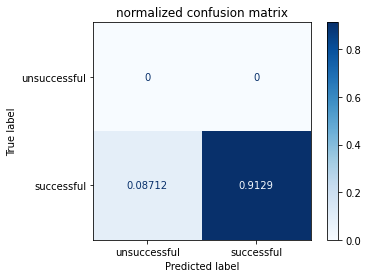

In [108]:
X_success_test = sudf[count:].reset_index(drop=True)
y_success_test = np.ones(len(X_success_test))

disp = plot_confusion_matrix(clf, X_success_test, y_success_test,
                             display_labels=['unsuccessful','successful'],
                             cmap=plt.cm.Blues,
                             normalize='true',
                            values_format='.4g')
disp.ax_.set_title('normalized confusion matrix')
print(disp.confusion_matrix)

In [109]:
sudf = sudf_main.drop(['MPI National', 'MPI Regional', 'Headcount Ratio Regional', 'Intensity of deprivation Regional'], axis=1)
undf = undf_main.drop(['MPI National', 'MPI Regional', 'Headcount Ratio Regional', 'Intensity of deprivation Regional'], axis=1)

### Oversampled MLPClassifier
This dataset involves a technique called oversampling. Since we have less unsuccessful data, we'd like to oversample
the existing data. That way, we can use more unique successful data, and enlarge the general size of the data set.

## Composition

For this training cycle, we split the unsuccessful loans again into two parts:

two thirds - for training (to be oversampled)
a third - for testing
We took a corresponding amount of successful loans for both training and test sets.

In [110]:
from collections import Counter

# undf - take only 2/3 of the data for training
sudf_training_count = int(len(sudf) * 2 / 3)
undf_training_count = int(len(undf) * 2 / 3)

# predict test set - 1/3 of the undf data
sudf_test_count = int(len(sudf) / 3)
undf_test_count = int(undf_training_count / 2)

Y_to_re = []
Y_to_re.extend(np.zeros(undf_training_count)) # for unsuccessful loans - undf
Y_to_re.extend(np.ones(sudf_training_count)) # for successful loans - sudf
Y_to_re = np.array(Y_to_re)
X_to_re = pd.concat([undf[:undf_training_count], sudf[:sudf_training_count]], ignore_index=True)
print(f'size of training (x): {len(X_to_re)}, size of training label (Y): {len(Y_to_re)}')

test_undf = undf[-undf_test_count:]
test_sudf = sudf[-undf_test_count:]
X_test_to_re = pd.concat([test_undf, test_sudf], ignore_index=True).reset_index(drop=True)
Y_test_to_re = np.concatenate((np.zeros(undf_test_count), np.ones(undf_test_count)))
print(f'size of test (x): {len(X_test_to_re)}, size of test label (Y): {len(Y_test_to_re)}')

print(Counter(Y_to_re))

size of training (x): 443410, size of training label (Y): 443410
size of test (x): 32136, size of test label (Y): 32136
Counter({1.0: 411274, 0.0: 32136})


### Oversampling
Here we extend the unsuccessful loans to be the same size as the successful loans, using oversampling.

In [111]:
from imblearn.over_sampling import SMOTE

X_resampled, Y_resampled = SMOTE(sampling_strategy='minority').fit_resample(X_to_re,Y_to_re)
print(f'new size of training samples (x): {len(X_resampled)}, training labeled (Y): {len(Y_resampled)}')

print(Counter(Y_resampled))

new size of training samples (x): 822548, training labeled (Y): 822548
Counter({0.0: 411274, 1.0: 411274})


### Training

In [112]:
# train a model
classifier_resampling = MLPClassifier(max_iter=500, hidden_layer_sizes=(15, 15, 15))
clf_resampling = make_pipeline(StandardScaler(),classifier_resampling)
clf_resampling.fit(X_resampled, Y_resampled)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=(15, 15, 15), max_iter=500))])

### Testing

[[0.85548917 0.14451083]
 [0.04574309 0.95425691]]


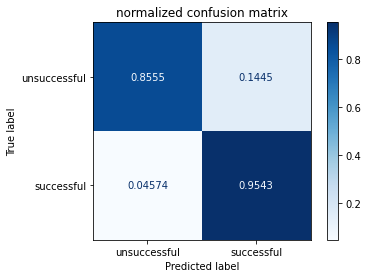

In [113]:
# predict test set
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(clf_resampling, X_test_to_re, Y_test_to_re,
                             display_labels=['unsuccessful','successful'],
                             cmap=plt.cm.Blues,
                             normalize='true',
                            values_format='.4g')
disp.ax_.set_title('normalized confusion matrix')
print(disp.confusion_matrix)

### Results Analysis
The results (compared to the Basic MLPClassifier) on the successful loans remain the same. However, the unsuccessful
loans seem to be worse. The oversampling might be too aggressive, or it might just not be the right solution to the
problem.

## Regional MPI MLPClassifier

For this model training, we partially extracted the regional data from MPI. We extracted a large portion of the
regions, and after seeing the initial results we concluded that this direction does not improve.
We've filled MPI, head count and Intensity with 0s.
Please note that the name is "regional MPI" and not just "MPI", since the country MPI data is already included in all
the previous models. Here we add the regional MPI data.


### Preprocessing - Merge Regional MPI

### Filter Columns

In [114]:
undf1 = undf_main
sudf1 = sudf_main

## Prepare train and test samples

In [115]:
# take only 2/3 of the data for training (based on undf size, since undf is 39,878 and sudf is 550,560)
count = int(len(undf1) * 2 / 3)
print(f'size of training set (successful and unsuccessful): {count*2}')
Y = []
Y.extend(np.zeros(count)) # for unsuccessful loans - undf
Y.extend(np.ones(count)) # for successful loans - sudf
Y = np.array(Y)
X = pd.concat([undf1[:count], sudf1[:count]], ignore_index=True)

# predict test set - 1/3 of the undf data, or 1/2 of the training set
end_test_set_count = int(3*count/2) + 1
print(f'size of test set (successful and unsuccessful): {count}')

X_test = pd.concat([undf1[count:], sudf1[count:end_test_set_count]], ignore_index=True).reset_index(drop=True)
#X_test = np.concatenate((predict_unsuc, predict_suc))
y_test = np.concatenate((np.zeros(int(count/2)+1), np.ones(int(count/2)+1)))

size of training set (successful and unsuccessful): 64272
size of test set (successful and unsuccessful): 32136


## Training

In [116]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    classifier = MLPClassifier(max_iter=200, hidden_layer_sizes=(20, 20, 20,))

clf1 = make_pipeline(StandardScaler(),classifier)
clf1.fit(X, Y)

C:\Users\eyalg\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=(20, 20, 20)))])

## Testing

[[0.92799801 0.07200199]
 [0.08836891 0.91163109]]


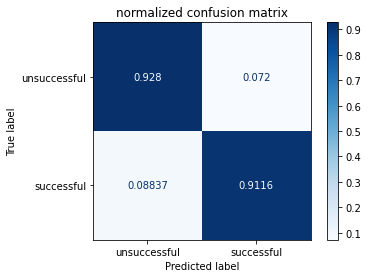

In [117]:
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(clf1, X_test, y_test,
                             display_labels=['unsuccessful','successful'],
                             cmap=plt.cm.Blues,
                             normalize='true',
                            values_format='.4g')
disp.ax_.set_title('normalized confusion matrix')
print(disp.confusion_matrix)

#### Results

Most of the unsuccessful loans have monthly repayment interval, while almost 50% of the successful loans have irregular
interval.

It seems a bit odd, since borrowers might prefer a safer repayment method, but this is probably a classic
case of causation != correlation. There's probably a different cause for this diff on the interval rate, but
nevertheless it can be a useful feature.

# <a class="anchor" id="results">5. Final results</a>

Let's summarize the results:

* There is a visible connection between the gender, and the success of the loan - There were allot more successful loans
by females than by males - by a large margin. Also, looking at unsuccessful loans - there is a balance between the
number of unsuccessful loans by males and females

* words such as "water", "safe drinking", "water filter" are used in
successful loans, whereas "buy", "sell", "soft drink" and "business" are used more in unsuccessful loans.

* Successful loans have a shorter but richer sentence in the use field.

* The tags: Technology, Fabrics, Eco-Friendly, Health and Sanitation are the top
 tags for successful loans. However, the Refugee and Interesting photo tags were always in unsuccessful loans.

* The sectors in which loans had a high success rate were Personal use, Education and food.

* For each sector, the average loan amount is greater on unsuccessful loans.

* On average, unsuccessful loans request for a longer term to return the loans.

* Most of the unsuccessful loans have monthly repayment interval, while almost 50% of the successful loans have irregular
interval.

* The Regional MPI MLPClassifier provided the best results and showed that we can predict the successful and
unsuccessful loans with relatively high accuracy.

# <a class="anchor" id="conclusions">6. Conclusions</a>

Based on the results, we reached the following conclusions:

* A lender is more likely to support a loan request with a humanitarian use, such as loans for water filtering in order
to provide clean water. As kiva is crowdfunding platform for the third-world - it seems that the lenders are more
sensitive to loans for basic human needs, and therefore they to support such projects.

* A lender is also likely to support a loan request for entrepreneurial purposes
(for example, loans for a technological venture). Looking at the results, the phrase "give a man a fish and you feed
him for a day; teach a man to fish, and you feed him for a lifetime" comes to mind. Lenders prefer to help those in
need in Third World countries - to become self-sufficient.

* A lender is more likely to support loans that request a modest amount of money. Lenders fear that loans that request
a large sum of money, will have trouble returning the loan in the future.

* A lender is more likely to support a loan request by a female. Looking at the results, we thought about two reasons
that might cause lenders to be more supportive of loans by females:
    * Lenders tend to be more sympathetic for women and feel that women are weaker especially in Third World countries,
    and therefore need their support more than males.
    * Lenders might feel that women borrowers are more responsible than male borrowers, and therefore gave more thought
    and planing for what they are requesting the loan for, and therefore are more likely to return the loan.

* Using the Regional MPI data gave the DNN model more insight about the loans and therefore was able to give slightly
more accurate predictions.

## Obstacles
Along the way we had some bugs that shifted our results, the most significant bug was the biased encoding,
it improved our success rate significantly, and we didn't suspect this bug until we reviewed some of our code. <br>
Another, less impactful bug was merging the MPI and loans dataset. We didn't set the 'how' parameter, and ended up
losing 80k entries which surprisingly didn't affect the results too badly. <br><br>

## Summary
We faced various challenges in this project: missing values, features that require preprocessing, crossing data with
other datasets, dealing with imbalanced datasets, and figuring out the best model for predicting the best results.
Each challenge required different tools and attitude, and we presented the solutions we offered to overcome them.
In some cases, we compared a few solutions.<br>
One of the biggest challenges of the project was the feature extraction, and it came into effect with the largest
section of our notebook dedicated to feature extraction. The model training and fine-tuning was also a major
challenge.<br>
Our end goal was to predict whether a loan will get fully funded on Kiva platform or not, and we managed to get a
decent result at the end. Using the the Basic MLPClassiifer and the Regional MPI MLPClassifier we can get
a prediction with 91% success rate whether a loan will be successful or not, using the Oversampled MLPClassifier
model we can predict successful loans with success rate of almost 95%(!) but an unsuccessful loan with 85% success
rate. <br><br>